In [15]:
import impaintingLib as imp
import torch 
import matplotlib.pyplot as plt

def plot(image):
    image = torch.clip(image,0,1)
    plt.figure(figsize=(4,3))
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

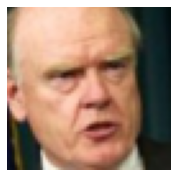

In [3]:
trainloader, testloader = imp.data.getFaces(shuffle=False,doNormalize=False)
imgs, _ = next(iter(testloader))

img = imgs[0]
plot(img)

torch.Size([3, 64, 64])
torch.Size([1, 64, 64])
tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])


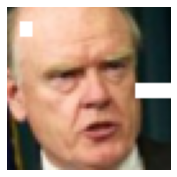

In [4]:
c, h, w = img.shape

w11 = 5
h11 = 6
        
w22 = 50
h22 = 30

print(img.shape)
        
# cutouts = torch.empty((1, h, w), dtype=img.dtype, device=img.device)
cutouts = torch.full((1,h,w),255, dtype=img.dtype, device=img.device)
cutouts[:, h11:h11 + h11, w11:w11 + w11] = 0
cutouts[:, h22:h22 + h11, w22:w22 + w22] = 0

print(cutouts.shape)

res = torch.cat((img,cutouts),0)
plot(res)

print(res[-1])

In [5]:
imgs, _ = next(iter(testloader))

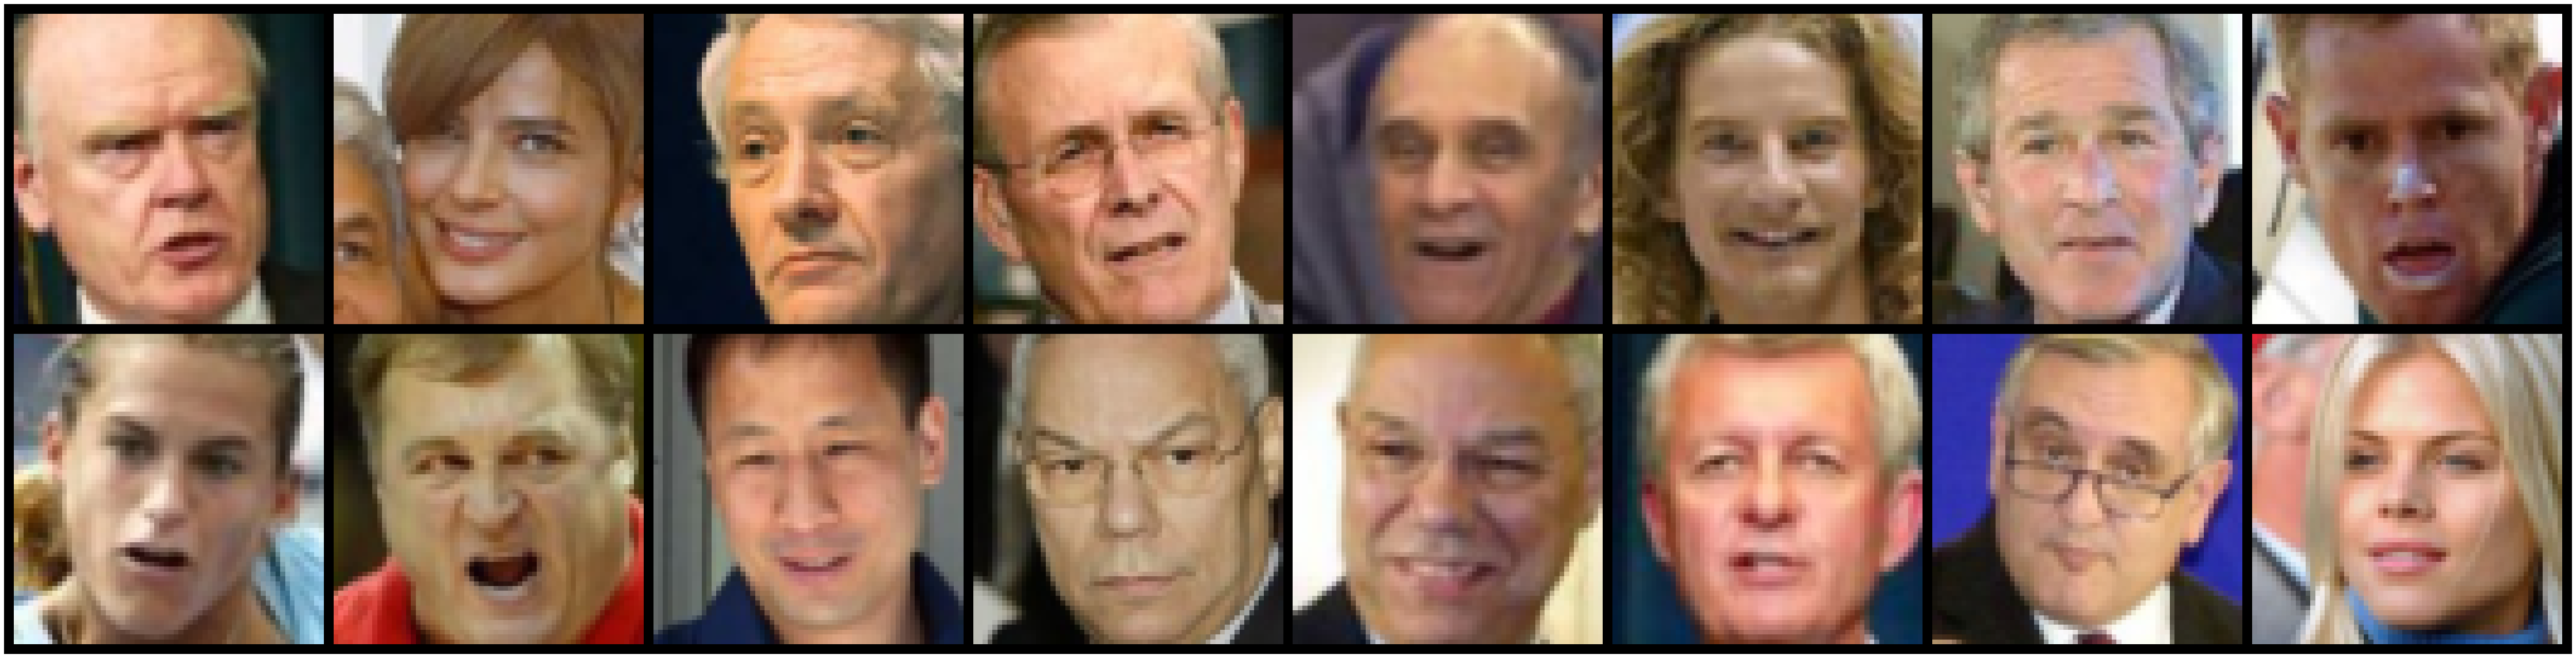

In [6]:
visu = imp.utils.Visu()
visu.plot_img(imgs)

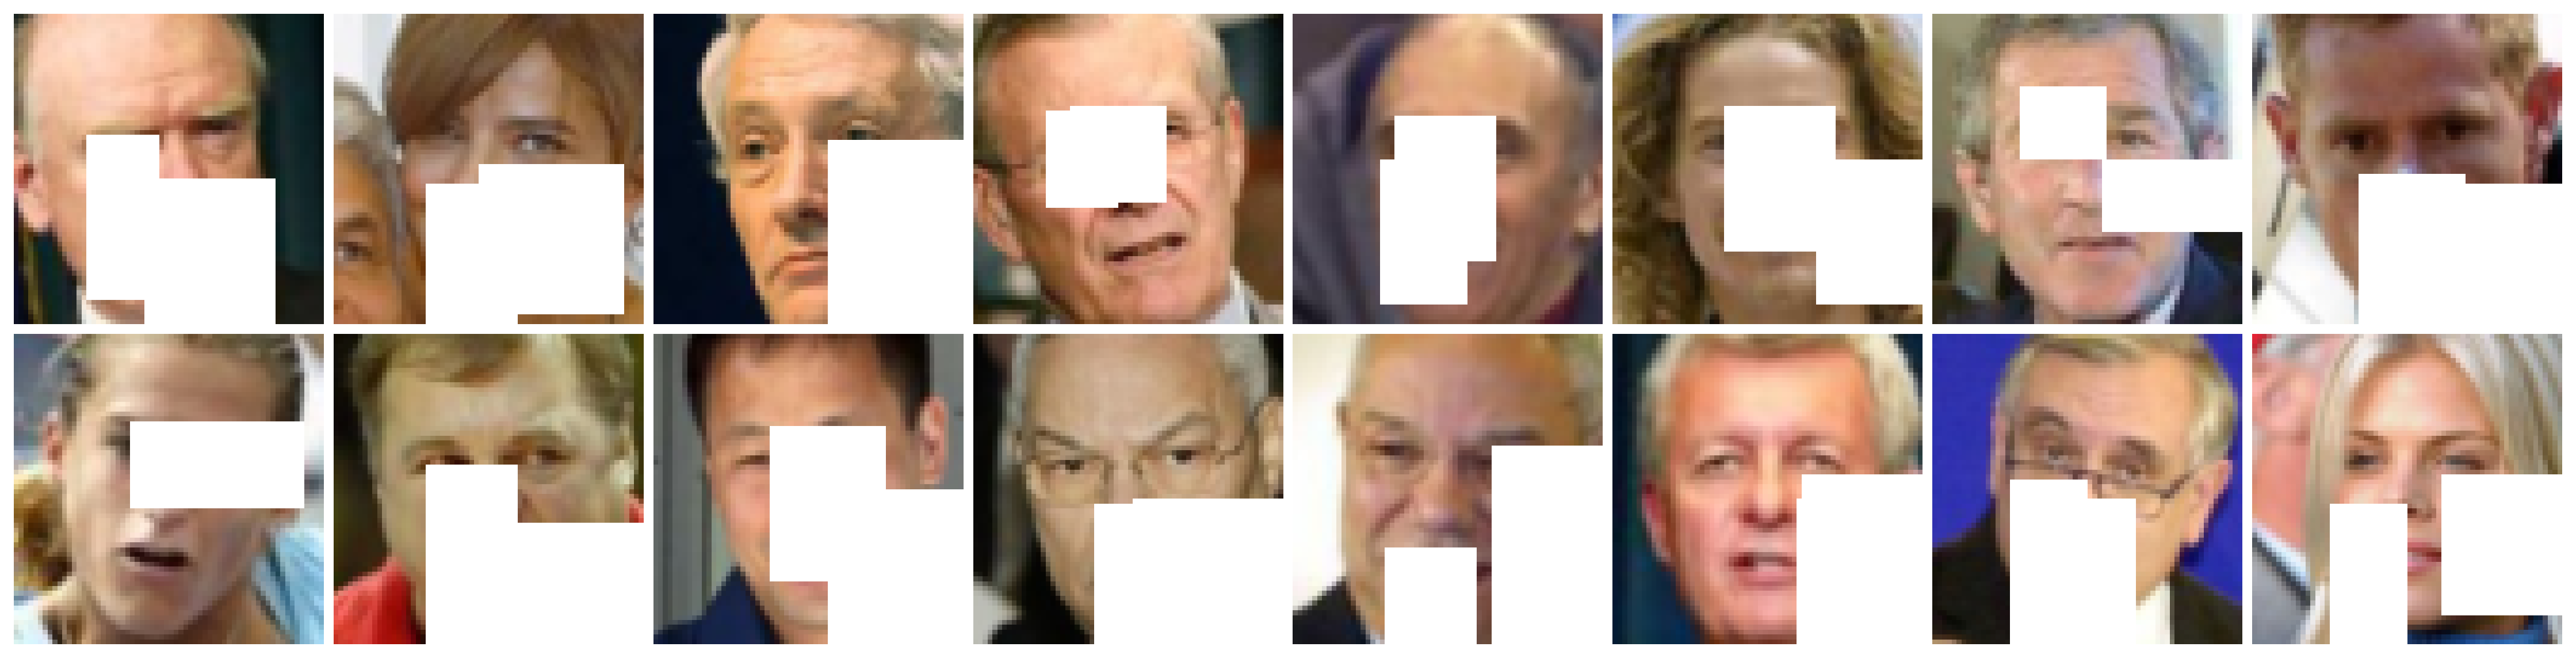

In [7]:
alter = imp.mask.Alter()
imgs = alter.squareMask(imgs)
visu.plot_img(imgs)

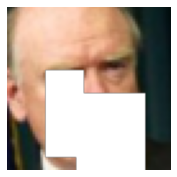

In [8]:
img = imgs[0]
plot(img)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


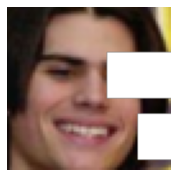

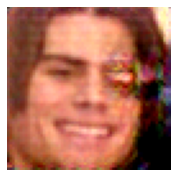

In [48]:
import impaintingLib as imp
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image

def plot(image):
    image = torch.clip(image,0,1)
    plt.figure(figsize=(4,3))
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = imp.model.UNet().to(device)
model = imp.model.AutoEncoder().to(device)
model = imp.process.model_load(model,"Autoencode_Perceptualvgg_+_L1_+_Totalvar_Epoch30")

alterFunc = imp.mask.Alter(min_cut=4, max_cut=60, seed=1).squareMask
# trainloader, testloader = imp.data.getFaces(shuffle=False)
# imgs, _ = next(iter(testloader))


with Image.open("./data/lfw/AJ_Lamas/AJ_Lamas_0001.jpg") as image:
    resize = (120, 120)
    crop   = (64 , 64 )
    transformations = transforms.Compose([
         transforms.Resize(resize), 
         transforms.CenterCrop(crop),
         transforms.ToTensor()
    ])
    image = transformations(image)

    print(image.shape)
imgs = image.view(1,3,64,64)
imgs = imgs.to(device)
imgs = alterFunc(imgs)
img = imgs[0].cpu().detach()
plot(img)

imgs = model(imgs).cpu()
img = imgs[0].cpu().detach()
print(img.shape)
#img = imp.data.inv_normalize(img)

plot(img)
save_image(img, './savedImages/yanis/31.jpg')

1
color


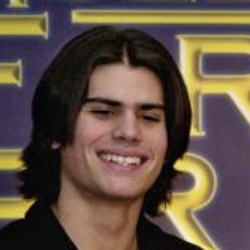

0


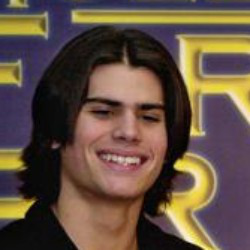

1
mirror


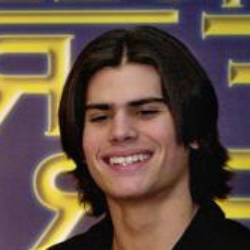

1
mirror


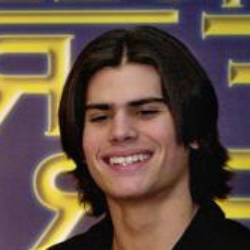

1
color


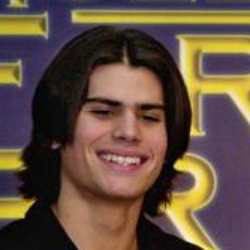

1
zoom


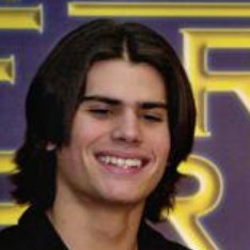

1
lumi


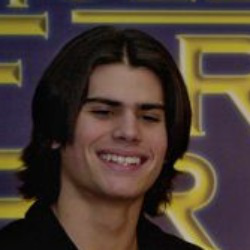

1
mirror


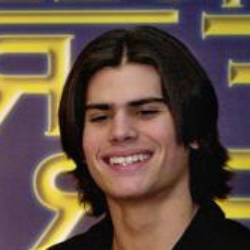

1
rotation


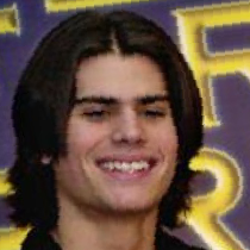

1
color


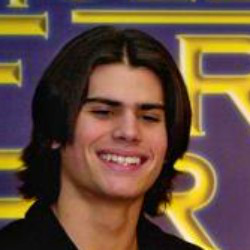

In [383]:
from PIL import Image, ImageEnhance
import numpy as np
import math
import random

def zoom(img,factor=0):
    size = (width, height) = (img.size)
    
    # Si on ne lui donne pas d'arg alors c'est aléatoire
    if factor < 1 :
        (mu,sigma) = (3,7)
        factor = abs(factor)
        factor = np.random.normal(mu, sigma)
    
    (left, upper, right, lower) = (factor, factor, height-factor, width-factor)
    img = img.crop((left, upper, right, lower))
    img = img.resize(size)
    return img
    
def rotation(img):
    (mu,sigma) = (5,5)
    factor = np.random.normal(mu, sigma)
    factor = abs(factor)
    img = img.rotate(factor)
    img = zoom(img,20)
    return img

def mirror(img):
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    return img

def enhance(img,enhancer):
    (mu,sigma) = (1,0.15)
    factor = np.random.normal(mu, sigma)
    img = enhancer.enhance(factor)
    return img
    
def lumi(img):
    func = ImageEnhance.Brightness(img)
    return enhance(img,func)

def contrast(img):
    func = ImageEnhance.Contrast(img)
    return enhance(img,func)

def color(img):
    func = ImageEnhance.Color(img)
    return enhance(img,func)

def sharpness(img):
    func = ImageEnhance.Sharpness(img)
    return enhance(img,func)

def randomTransfo(img):
    (mu,sigma) = (1.3,0.25)
    nbTransfo = np.random.normal(mu, sigma)
    nbTransfo = abs(nbTransfo)
    nbTransfo = int(nbTransfo)
    
    print(nbTransfo)
    transfos = [zoom, rotation, mirror, lumi, contrast, color, sharpness]
    for i in range(nbTransfo):
        func = random.choice(transfos)
        print(func. __name__)
        transfos.remove(func)
        img = func(img)
    
    return img

path = "./data/lfw/AJ_Lamas/AJ_Lamas_0001.jpg"

for i in range(10):
    with Image.open(path) as img:
        img = randomTransfo(img)
        img.show()
    